In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as pl
from torchvision import datasets, transforms

In [0]:
torch.manual_seed(1)
batch_size = 32
use_cuda = torch.cuda.is_available()

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                        transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=False, **kwargs)



# SEED = 1

# # CUDA?
# cuda = torch.cuda.is_available()
# print("CUDA Available?", cuda)

# # For reproducibility
# torch.manual_seed(SEED)

# if cuda:
#     torch.cuda.manual_seed(SEED)

# # dataloader arguments - something you'll fetch these from cmdprmt
# dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# # train dataloader
# train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# # test dataloader
# test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

In [0]:
drop_val = 0.001
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(drop_val)
        ) # output_size = 28
        # RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.ReLU(),
            nn.Dropout(drop_val)
        ) # output_size = 28
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # output_size = 28

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 14
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.ReLU(),
            #nn.Dropout(drop_val)
        ) # output_size = 14

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.ReLU(),
            nn.Dropout(drop_val)
        ) # output_size = 14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            #nn.ReLU(),
            #nn.BatchNorm2d(16),
            #nn.Dropout(drop_val),
            #nn.ReLU()
        ) # output_size = 14

        self.pool2 =nn.MaxPool2d(2,2)
        # Output size = 7
        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.ReLU(),
            nn.Dropout(drop_val)
        ) # 
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            #nn.ReLU(),
            nn.Dropout(drop_val)
        ) 

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=7)
        ) # output_size = 1
        
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )
        #self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool2(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [4]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
       BatchNorm2d-3           [-1, 10, 28, 28]              20
           Dropout-4           [-1, 10, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           1,440
              ReLU-6           [-1, 16, 28, 28]               0
       BatchNorm2d-7           [-1, 16, 28, 28]              32
           Dropout-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 10, 28, 28]             160
        MaxPool2d-10           [-1, 10, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           1,440
             ReLU-12           [-1, 16, 14, 14]               0
      BatchNorm2d-13           [-1, 16, 14, 14]              32
           Conv2d-14           [-1

In [0]:
from tqdm import tqdm
EPOCHS = 40
no_test_losses = []
no_train_loss = []
no_valid_acc = []

new_train_losses_l2 =[]
new_valid_losses_l2 =[]
l2_valid_acc = []

new_train_losses_l1 =[]
new_valid_losses_l1 =[]
l1_valid_acc = []

new_valid_losses_both = []
new_train_losses_both = []
both_valid_acc= []




No loss


In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
pred_list = []

def no_train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  total_train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.nll_loss(y_pred, target)
    total_train_loss += loss.item()
    
    #train_losses.append(loss.item())


    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  total_train_loss = total_train_loss/(batch_idx+1)
  no_train_loss.append(total_train_loss)


def no_test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_list.append(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()

    no_test_losses.append(test_loss)
    test_loss /= len(test_loader.dataset)
    

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    no_valid_acc.append(100. * correct / len(test_loader.dataset))




In [7]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.04, momentum=0, weight_decay = 0.0003 dampening=0, nesterov=False)
optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
#EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    no_train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    no_test(model, device, test_loader)

  0%|          | 0/1875 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.1854165494441986 Batch_id=1874 Accuracy=92.47: 100%|██████████| 1875/1875 [00:36<00:00, 51.10it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9854/10000 (98.54%)

EPOCH: 2


Loss=0.2860129773616791 Batch_id=1874 Accuracy=97.39: 100%|██████████| 1875/1875 [00:36<00:00, 50.75it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0427, Accuracy: 9858/10000 (98.58%)

EPOCH: 3


Loss=0.042593538761138916 Batch_id=1874 Accuracy=97.84: 100%|██████████| 1875/1875 [00:36<00:00, 50.87it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0420, Accuracy: 9854/10000 (98.54%)

EPOCH: 4


Loss=0.0054135918617248535 Batch_id=1874 Accuracy=98.68: 100%|██████████| 1875/1875 [00:36<00:00, 53.44it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9923/10000 (99.23%)

EPOCH: 5


Loss=0.0060739666223526 Batch_id=1874 Accuracy=98.72: 100%|██████████| 1875/1875 [00:37<00:00, 51.03it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0218, Accuracy: 9924/10000 (99.24%)

EPOCH: 6


Loss=0.03768191486597061 Batch_id=1874 Accuracy=98.84: 100%|██████████| 1875/1875 [00:37<00:00, 50.20it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.009640917181968689 Batch_id=1874 Accuracy=98.85: 100%|██████████| 1875/1875 [00:36<00:00, 50.92it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9925/10000 (99.25%)

EPOCH: 8


Loss=0.008096739649772644 Batch_id=1874 Accuracy=98.92: 100%|██████████| 1875/1875 [00:37<00:00, 50.52it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.006748884916305542 Batch_id=1874 Accuracy=98.92: 100%|██████████| 1875/1875 [00:36<00:00, 50.82it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=0.0366082638502121 Batch_id=1874 Accuracy=98.87: 100%|██████████| 1875/1875 [00:36<00:00, 50.95it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.008192434906959534 Batch_id=1874 Accuracy=98.87: 100%|██████████| 1875/1875 [00:37<00:00, 51.01it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.010906010866165161 Batch_id=1874 Accuracy=98.92: 100%|██████████| 1875/1875 [00:37<00:00, 50.54it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.0007929503917694092 Batch_id=1874 Accuracy=98.88: 100%|██████████| 1875/1875 [00:37<00:00, 50.59it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9927/10000 (99.27%)

EPOCH: 14


Loss=0.030999362468719482 Batch_id=1874 Accuracy=98.91: 100%|██████████| 1875/1875 [00:37<00:00, 50.61it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.0008841753005981445 Batch_id=1874 Accuracy=98.97: 100%|██████████| 1875/1875 [00:37<00:00, 50.33it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9929/10000 (99.29%)

EPOCH: 16


Loss=0.16804437339305878 Batch_id=1874 Accuracy=98.91: 100%|██████████| 1875/1875 [00:36<00:00, 52.32it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9931/10000 (99.31%)

EPOCH: 17


Loss=0.18705931305885315 Batch_id=1874 Accuracy=98.90: 100%|██████████| 1875/1875 [00:36<00:00, 50.76it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.012047111988067627 Batch_id=1874 Accuracy=98.91: 100%|██████████| 1875/1875 [00:36<00:00, 48.53it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9927/10000 (99.27%)

EPOCH: 19


Loss=0.002458631992340088 Batch_id=1874 Accuracy=98.90: 100%|██████████| 1875/1875 [00:37<00:00, 50.48it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9928/10000 (99.28%)

EPOCH: 20


Loss=0.014809578657150269 Batch_id=1874 Accuracy=98.95: 100%|██████████| 1875/1875 [00:37<00:00, 50.17it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9926/10000 (99.26%)

EPOCH: 21


Loss=0.1358984410762787 Batch_id=1874 Accuracy=98.94: 100%|██████████| 1875/1875 [00:37<00:00, 49.85it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9929/10000 (99.29%)

EPOCH: 22


Loss=0.011898934841156006 Batch_id=1874 Accuracy=98.92: 100%|██████████| 1875/1875 [00:37<00:00, 50.24it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9929/10000 (99.29%)

EPOCH: 23


Loss=0.009008333086967468 Batch_id=1874 Accuracy=98.92: 100%|██████████| 1875/1875 [00:37<00:00, 50.20it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9926/10000 (99.26%)

EPOCH: 24


Loss=0.06968192756175995 Batch_id=1874 Accuracy=98.87: 100%|██████████| 1875/1875 [00:37<00:00, 50.58it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9924/10000 (99.24%)

EPOCH: 25


Loss=0.0875677540898323 Batch_id=1874 Accuracy=98.97: 100%|██████████| 1875/1875 [00:37<00:00, 50.39it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9928/10000 (99.28%)

EPOCH: 26


Loss=0.008479326963424683 Batch_id=1874 Accuracy=98.92: 100%|██████████| 1875/1875 [00:38<00:00, 49.33it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9930/10000 (99.30%)

EPOCH: 27


Loss=0.002616018056869507 Batch_id=1874 Accuracy=98.89: 100%|██████████| 1875/1875 [00:38<00:00, 48.85it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9928/10000 (99.28%)

EPOCH: 28


Loss=0.04543158411979675 Batch_id=1874 Accuracy=98.88: 100%|██████████| 1875/1875 [00:37<00:00, 49.59it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9919/10000 (99.19%)

EPOCH: 29


Loss=0.005919739603996277 Batch_id=1874 Accuracy=98.91: 100%|██████████| 1875/1875 [00:38<00:00, 48.20it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9928/10000 (99.28%)

EPOCH: 30


Loss=0.019255980849266052 Batch_id=1874 Accuracy=98.85: 100%|██████████| 1875/1875 [00:38<00:00, 48.98it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9928/10000 (99.28%)

EPOCH: 31


Loss=0.029695838689804077 Batch_id=1874 Accuracy=98.88: 100%|██████████| 1875/1875 [00:37<00:00, 53.04it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0213, Accuracy: 9927/10000 (99.27%)

EPOCH: 32


Loss=0.029804810881614685 Batch_id=1874 Accuracy=98.90: 100%|██████████| 1875/1875 [00:37<00:00, 49.76it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9925/10000 (99.25%)

EPOCH: 33


Loss=0.030810430645942688 Batch_id=1874 Accuracy=98.93: 100%|██████████| 1875/1875 [00:37<00:00, 49.54it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9928/10000 (99.28%)

EPOCH: 34


Loss=0.06609302759170532 Batch_id=1874 Accuracy=98.93: 100%|██████████| 1875/1875 [00:36<00:00, 50.93it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Accuracy: 9924/10000 (99.24%)

EPOCH: 35


Loss=0.0018506795167922974 Batch_id=1874 Accuracy=98.91: 100%|██████████| 1875/1875 [00:37<00:00, 53.32it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9928/10000 (99.28%)

EPOCH: 36


Loss=0.005454704165458679 Batch_id=1874 Accuracy=98.87: 100%|██████████| 1875/1875 [00:37<00:00, 49.87it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9928/10000 (99.28%)

EPOCH: 37


Loss=0.2682195007801056 Batch_id=1874 Accuracy=98.96: 100%|██████████| 1875/1875 [00:37<00:00, 53.64it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9929/10000 (99.29%)

EPOCH: 38


Loss=0.013294652104377747 Batch_id=1874 Accuracy=98.86: 100%|██████████| 1875/1875 [00:36<00:00, 50.72it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9929/10000 (99.29%)

EPOCH: 39


Loss=0.013427242636680603 Batch_id=1874 Accuracy=98.90: 100%|██████████| 1875/1875 [00:36<00:00, 50.70it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0208, Accuracy: 9926/10000 (99.26%)

EPOCH: 40


Loss=0.017202451825141907 Batch_id=1874 Accuracy=98.88: 100%|██████████| 1875/1875 [00:36<00:00, 50.83it/s]



Test set: Average loss: 0.0205, Accuracy: 9930/10000 (99.30%)



In [8]:
print (len(no_train_loss))
print (len(no_valid_acc))

40
40


For L2


In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
pred_list = []
def train_l2(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  loss = 0
  correct = 0
  processed = 0
  total_train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)
    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)
    loss = F.nll_loss(y_pred, target)
    total_train_loss += loss.item()
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()
 

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

  total_train_loss = total_train_loss/(batch_idx+1)

  new_train_losses_l2.append(loss.item())

def test_l2(model, device, test_loader):
    
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_list.append(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    new_valid_losses_l2.append(test_loss)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    #test_loss = test_loss/(batch_idx+1)
    l2_valid_acc.append(100. * correct / len(test_loader.dataset))


In [10]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.04, momentum=0, weight_decay = 0.0003, dampening=0, nesterov=False)
#optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
#EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_l2(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test_l2(model, device, test_loader)

  0%|          | 0/1875 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.08985917270183563 Batch_id=1874 Accuracy=87.48: 100%|██████████| 1875/1875 [00:37<00:00, 49.63it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0861, Accuracy: 9768/10000 (97.68%)

EPOCH: 2


Loss=0.08284366130828857 Batch_id=1874 Accuracy=96.62: 100%|██████████| 1875/1875 [00:36<00:00, 51.33it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0627, Accuracy: 9797/10000 (97.97%)

EPOCH: 3


Loss=0.08168692886829376 Batch_id=1874 Accuracy=97.34: 100%|██████████| 1875/1875 [00:36<00:00, 51.66it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0581, Accuracy: 9811/10000 (98.11%)

EPOCH: 4


Loss=0.059722743928432465 Batch_id=1874 Accuracy=98.14: 100%|██████████| 1875/1875 [00:36<00:00, 51.11it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.028346270322799683 Batch_id=1874 Accuracy=98.25: 100%|██████████| 1875/1875 [00:36<00:00, 51.51it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Loss=0.00774499773979187 Batch_id=1874 Accuracy=98.30: 100%|██████████| 1875/1875 [00:36<00:00, 51.56it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


Loss=0.06465817987918854 Batch_id=1874 Accuracy=98.39: 100%|██████████| 1875/1875 [00:36<00:00, 51.22it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.2236718386411667 Batch_id=1874 Accuracy=98.39: 100%|██████████| 1875/1875 [00:36<00:00, 51.23it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9915/10000 (99.15%)

EPOCH: 9


Loss=0.11527153849601746 Batch_id=1874 Accuracy=98.43: 100%|██████████| 1875/1875 [00:37<00:00, 52.89it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9911/10000 (99.11%)

EPOCH: 10


Loss=0.07196804881095886 Batch_id=1874 Accuracy=98.44: 100%|██████████| 1875/1875 [00:36<00:00, 50.70it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9919/10000 (99.19%)

EPOCH: 11


Loss=0.05283300578594208 Batch_id=1874 Accuracy=98.45: 100%|██████████| 1875/1875 [00:36<00:00, 51.41it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.016129180788993835 Batch_id=1874 Accuracy=98.47: 100%|██████████| 1875/1875 [00:37<00:00, 50.13it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9916/10000 (99.16%)

EPOCH: 13


Loss=0.048591144382953644 Batch_id=1874 Accuracy=98.37: 100%|██████████| 1875/1875 [00:37<00:00, 50.14it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9916/10000 (99.16%)

EPOCH: 14


Loss=0.018118083477020264 Batch_id=1874 Accuracy=98.42: 100%|██████████| 1875/1875 [00:36<00:00, 51.18it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9920/10000 (99.20%)

EPOCH: 15


Loss=0.013385489583015442 Batch_id=1874 Accuracy=98.45: 100%|██████████| 1875/1875 [00:36<00:00, 50.98it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9918/10000 (99.18%)

EPOCH: 16


Loss=0.004594013094902039 Batch_id=1874 Accuracy=98.45: 100%|██████████| 1875/1875 [00:36<00:00, 50.70it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9919/10000 (99.19%)

EPOCH: 17


Loss=0.01358821988105774 Batch_id=1874 Accuracy=98.45: 100%|██████████| 1875/1875 [00:36<00:00, 51.25it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9917/10000 (99.17%)

EPOCH: 18


Loss=0.1206246092915535 Batch_id=1874 Accuracy=98.42: 100%|██████████| 1875/1875 [00:36<00:00, 54.09it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9919/10000 (99.19%)

EPOCH: 19


Loss=0.004945039749145508 Batch_id=1874 Accuracy=98.46: 100%|██████████| 1875/1875 [00:37<00:00, 50.57it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0289, Accuracy: 9915/10000 (99.15%)

EPOCH: 20


Loss=0.029552966356277466 Batch_id=1874 Accuracy=98.49: 100%|██████████| 1875/1875 [00:37<00:00, 50.55it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9913/10000 (99.13%)

EPOCH: 21


Loss=0.01955011487007141 Batch_id=1874 Accuracy=98.45: 100%|██████████| 1875/1875 [00:36<00:00, 55.11it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9921/10000 (99.21%)

EPOCH: 22


Loss=0.025556564331054688 Batch_id=1874 Accuracy=98.48: 100%|██████████| 1875/1875 [00:36<00:00, 50.83it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9922/10000 (99.22%)

EPOCH: 23


Loss=0.013980239629745483 Batch_id=1874 Accuracy=98.44: 100%|██████████| 1875/1875 [00:36<00:00, 51.14it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9912/10000 (99.12%)

EPOCH: 24


Loss=0.033552274107933044 Batch_id=1874 Accuracy=98.52: 100%|██████████| 1875/1875 [00:36<00:00, 54.00it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0299, Accuracy: 9910/10000 (99.10%)

EPOCH: 25


Loss=0.07559803128242493 Batch_id=1874 Accuracy=98.44: 100%|██████████| 1875/1875 [00:36<00:00, 50.69it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9924/10000 (99.24%)

EPOCH: 26


Loss=0.006875902414321899 Batch_id=1874 Accuracy=98.43: 100%|██████████| 1875/1875 [00:36<00:00, 52.84it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9916/10000 (99.16%)

EPOCH: 27


Loss=0.015510022640228271 Batch_id=1874 Accuracy=98.45: 100%|██████████| 1875/1875 [00:36<00:00, 50.87it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9919/10000 (99.19%)

EPOCH: 28


Loss=0.016401633620262146 Batch_id=1874 Accuracy=98.45: 100%|██████████| 1875/1875 [00:36<00:00, 50.80it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9919/10000 (99.19%)

EPOCH: 29


Loss=0.01954115927219391 Batch_id=1874 Accuracy=98.44: 100%|██████████| 1875/1875 [00:36<00:00, 51.02it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9922/10000 (99.22%)

EPOCH: 30


Loss=0.02305997908115387 Batch_id=1874 Accuracy=98.48: 100%|██████████| 1875/1875 [00:36<00:00, 50.96it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9921/10000 (99.21%)

EPOCH: 31


Loss=0.007348969578742981 Batch_id=1874 Accuracy=98.46: 100%|██████████| 1875/1875 [00:36<00:00, 50.68it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9911/10000 (99.11%)

EPOCH: 32


Loss=0.10251805186271667 Batch_id=1874 Accuracy=98.47: 100%|██████████| 1875/1875 [00:36<00:00, 51.14it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9920/10000 (99.20%)

EPOCH: 33


Loss=0.010458335280418396 Batch_id=1874 Accuracy=98.46: 100%|██████████| 1875/1875 [00:37<00:00, 49.87it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9917/10000 (99.17%)

EPOCH: 34


Loss=0.029554933309555054 Batch_id=1874 Accuracy=98.43: 100%|██████████| 1875/1875 [00:37<00:00, 54.11it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9916/10000 (99.16%)

EPOCH: 35


Loss=0.03775690495967865 Batch_id=1874 Accuracy=98.47: 100%|██████████| 1875/1875 [00:36<00:00, 51.08it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9924/10000 (99.24%)

EPOCH: 36


Loss=0.049513451755046844 Batch_id=1874 Accuracy=98.47: 100%|██████████| 1875/1875 [00:37<00:00, 50.51it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9915/10000 (99.15%)

EPOCH: 37


Loss=0.05271600931882858 Batch_id=1874 Accuracy=98.44: 100%|██████████| 1875/1875 [00:36<00:00, 51.85it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9924/10000 (99.24%)

EPOCH: 38


Loss=0.020751982927322388 Batch_id=1874 Accuracy=98.39: 100%|██████████| 1875/1875 [00:36<00:00, 51.37it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9907/10000 (99.07%)

EPOCH: 39


Loss=0.041094668209552765 Batch_id=1874 Accuracy=98.45: 100%|██████████| 1875/1875 [00:36<00:00, 51.39it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9915/10000 (99.15%)

EPOCH: 40


Loss=0.02289465069770813 Batch_id=1874 Accuracy=98.40: 100%|██████████| 1875/1875 [00:36<00:00, 51.85it/s]



Test set: Average loss: 0.0290, Accuracy: 9921/10000 (99.21%)



In [11]:
print (len(new_train_losses_l2))
print (len(l2_valid_acc))

40
40


For L1


In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
pred_list = []
new_train_losses_l1=[]
def train_l1(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  loss = 0
  total_train_loss = 0
  #reg_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)
    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)
    #classify_loss = criterion(y_pred,target)
    #loss = classify_loss + LAMBDA* reg_loss
    loss = F.nll_loss(y_pred, target)
    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
        zero_vector = torch.rand_like(param) * 0
        reg_loss += l1_crit(param, zero_vector) 
    reg_loss = reg_loss / (batch_idx + 1)
    factor = 0.00005
    loss +=factor*reg_loss
    total_train_loss += loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  total_train_loss = total_train_loss / (batch_idx + 1)

  new_train_losses_l1.append(total_train_loss)

def test_l1(model, device, test_loader):
    
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_list.append(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()

    new_valid_losses_l1.append(test_loss) 
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print("length",len(test_losses))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    l1_valid_acc.append(100. * correct / len(test_loader.dataset))


In [13]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.04, momentum=0, dampening=0, nesterov=False)
optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9)
scheduler = StepLR(optimizer, step_size=40, gamma=0.1)
#EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_l1(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test_l1(model, device, test_loader)

  0%|          | 0/1875 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.14102886617183685 Batch_id=1874 Accuracy=92.68: 100%|██████████| 1875/1875 [00:43<00:00, 43.37it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 1

Test set: Average loss: 0.0608, Accuracy: 9809/10000 (98.09%)

EPOCH: 2


Loss=0.011303539387881756 Batch_id=1874 Accuracy=97.10: 100%|██████████| 1875/1875 [00:44<00:00, 42.48it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 2

Test set: Average loss: 0.0538, Accuracy: 9840/10000 (98.40%)

EPOCH: 3


Loss=0.003178816754370928 Batch_id=1874 Accuracy=97.66: 100%|██████████| 1875/1875 [00:43<00:00, 43.13it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 3

Test set: Average loss: 0.0432, Accuracy: 9867/10000 (98.67%)

EPOCH: 4


Loss=0.005683582741767168 Batch_id=1874 Accuracy=97.97: 100%|██████████| 1875/1875 [00:42<00:00, 43.90it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 4

Test set: Average loss: 0.0330, Accuracy: 9894/10000 (98.94%)

EPOCH: 5


Loss=0.049172986298799515 Batch_id=1874 Accuracy=98.20: 100%|██████████| 1875/1875 [00:43<00:00, 43.53it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 5

Test set: Average loss: 0.0334, Accuracy: 9907/10000 (99.07%)

EPOCH: 6


Loss=0.005140389781445265 Batch_id=1874 Accuracy=98.38: 100%|██████████| 1875/1875 [00:43<00:00, 43.09it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 6

Test set: Average loss: 0.0333, Accuracy: 9897/10000 (98.97%)

EPOCH: 7


Loss=0.20761613547801971 Batch_id=1874 Accuracy=98.46: 100%|██████████| 1875/1875 [00:43<00:00, 43.31it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 7

Test set: Average loss: 0.0284, Accuracy: 9908/10000 (99.08%)

EPOCH: 8


Loss=0.0016787948552519083 Batch_id=1874 Accuracy=98.56: 100%|██████████| 1875/1875 [00:42<00:00, 43.95it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 8

Test set: Average loss: 0.0283, Accuracy: 9903/10000 (99.03%)

EPOCH: 9


Loss=0.0013829903909936547 Batch_id=1874 Accuracy=98.57: 100%|██████████| 1875/1875 [00:41<00:00, 44.87it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 9

Test set: Average loss: 0.0274, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.006966735236346722 Batch_id=1874 Accuracy=98.62: 100%|██████████| 1875/1875 [00:42<00:00, 44.55it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 10

Test set: Average loss: 0.0259, Accuracy: 9914/10000 (99.14%)

EPOCH: 11


Loss=0.050511669367551804 Batch_id=1874 Accuracy=98.78: 100%|██████████| 1875/1875 [00:41<00:00, 45.98it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 11

Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.027600398287177086 Batch_id=1874 Accuracy=98.68: 100%|██████████| 1875/1875 [00:41<00:00, 45.00it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 12

Test set: Average loss: 0.0251, Accuracy: 9915/10000 (99.15%)

EPOCH: 13


Loss=0.03539718687534332 Batch_id=1874 Accuracy=98.75: 100%|██████████| 1875/1875 [00:41<00:00, 44.96it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 13

Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.01268834713846445 Batch_id=1874 Accuracy=98.81: 100%|██████████| 1875/1875 [00:41<00:00, 45.09it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 14

Test set: Average loss: 0.0248, Accuracy: 9920/10000 (99.20%)

EPOCH: 15


Loss=0.0026299154851585627 Batch_id=1874 Accuracy=98.87: 100%|██████████| 1875/1875 [00:42<00:00, 44.35it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 15

Test set: Average loss: 0.0233, Accuracy: 9920/10000 (99.20%)

EPOCH: 16


Loss=0.001019013812765479 Batch_id=1874 Accuracy=98.88: 100%|██████████| 1875/1875 [00:41<00:00, 45.11it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 16

Test set: Average loss: 0.0243, Accuracy: 9914/10000 (99.14%)

EPOCH: 17


Loss=0.02603197656571865 Batch_id=1874 Accuracy=98.93: 100%|██████████| 1875/1875 [00:42<00:00, 44.39it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 17

Test set: Average loss: 0.0246, Accuracy: 9918/10000 (99.18%)

EPOCH: 18


Loss=0.0017899798694998026 Batch_id=1874 Accuracy=98.98: 100%|██████████| 1875/1875 [00:42<00:00, 44.52it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 18

Test set: Average loss: 0.0236, Accuracy: 9919/10000 (99.19%)

EPOCH: 19


Loss=0.22023412585258484 Batch_id=1874 Accuracy=98.90: 100%|██████████| 1875/1875 [00:42<00:00, 44.90it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 19

Test set: Average loss: 0.0237, Accuracy: 9920/10000 (99.20%)

EPOCH: 20


Loss=0.01667119190096855 Batch_id=1874 Accuracy=98.98: 100%|██████████| 1875/1875 [00:41<00:00, 44.91it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 20

Test set: Average loss: 0.0208, Accuracy: 9932/10000 (99.32%)

EPOCH: 21


Loss=0.0009016436524689198 Batch_id=1874 Accuracy=99.03: 100%|██████████| 1875/1875 [00:42<00:00, 44.58it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 21

Test set: Average loss: 0.0222, Accuracy: 9919/10000 (99.19%)

EPOCH: 22


Loss=0.027789119631052017 Batch_id=1874 Accuracy=98.99: 100%|██████████| 1875/1875 [00:41<00:00, 45.50it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 22

Test set: Average loss: 0.0218, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Loss=0.000987498788163066 Batch_id=1874 Accuracy=99.01: 100%|██████████| 1875/1875 [00:41<00:00, 44.70it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 23

Test set: Average loss: 0.0274, Accuracy: 9912/10000 (99.12%)

EPOCH: 24


Loss=0.02663186937570572 Batch_id=1874 Accuracy=99.04: 100%|██████████| 1875/1875 [00:41<00:00, 45.02it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 24

Test set: Average loss: 0.0196, Accuracy: 9929/10000 (99.29%)

EPOCH: 25


Loss=0.06964590400457382 Batch_id=1874 Accuracy=99.02: 100%|██████████| 1875/1875 [00:41<00:00, 45.05it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 25

Test set: Average loss: 0.0238, Accuracy: 9919/10000 (99.19%)

EPOCH: 26


Loss=0.002295226790010929 Batch_id=1874 Accuracy=99.12: 100%|██████████| 1875/1875 [00:41<00:00, 45.34it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 26

Test set: Average loss: 0.0245, Accuracy: 9913/10000 (99.13%)

EPOCH: 27


Loss=0.007548417896032333 Batch_id=1874 Accuracy=99.05: 100%|██████████| 1875/1875 [00:41<00:00, 45.34it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 27

Test set: Average loss: 0.0215, Accuracy: 9922/10000 (99.22%)

EPOCH: 28


Loss=0.006475711241364479 Batch_id=1874 Accuracy=99.12: 100%|██████████| 1875/1875 [00:41<00:00, 45.16it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 28

Test set: Average loss: 0.0196, Accuracy: 9934/10000 (99.34%)

EPOCH: 29


Loss=0.0009502035682089627 Batch_id=1874 Accuracy=99.12: 100%|██████████| 1875/1875 [00:41<00:00, 45.23it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 29

Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)

EPOCH: 30


Loss=0.0025828133802860975 Batch_id=1874 Accuracy=99.11: 100%|██████████| 1875/1875 [00:41<00:00, 45.09it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 30

Test set: Average loss: 0.0204, Accuracy: 9926/10000 (99.26%)

EPOCH: 31


Loss=0.0013055738527327776 Batch_id=1874 Accuracy=99.13: 100%|██████████| 1875/1875 [00:41<00:00, 44.87it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 31

Test set: Average loss: 0.0201, Accuracy: 9928/10000 (99.28%)

EPOCH: 32


Loss=0.01021123118698597 Batch_id=1874 Accuracy=99.14: 100%|██████████| 1875/1875 [00:41<00:00, 45.68it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 32

Test set: Average loss: 0.0201, Accuracy: 9931/10000 (99.31%)

EPOCH: 33


Loss=0.04138355702161789 Batch_id=1874 Accuracy=99.17: 100%|██████████| 1875/1875 [00:42<00:00, 44.59it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 33

Test set: Average loss: 0.0215, Accuracy: 9928/10000 (99.28%)

EPOCH: 34


Loss=0.02852950245141983 Batch_id=1874 Accuracy=99.20: 100%|██████████| 1875/1875 [00:42<00:00, 44.34it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 34

Test set: Average loss: 0.0241, Accuracy: 9919/10000 (99.19%)

EPOCH: 35


Loss=0.0008333385339938104 Batch_id=1874 Accuracy=99.22: 100%|██████████| 1875/1875 [00:42<00:00, 44.22it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 35

Test set: Average loss: 0.0202, Accuracy: 9936/10000 (99.36%)

EPOCH: 36


Loss=0.002798068802803755 Batch_id=1874 Accuracy=99.23: 100%|██████████| 1875/1875 [00:42<00:00, 44.02it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 36

Test set: Average loss: 0.0221, Accuracy: 9932/10000 (99.32%)

EPOCH: 37


Loss=0.003975522704422474 Batch_id=1874 Accuracy=99.16: 100%|██████████| 1875/1875 [00:42<00:00, 44.33it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 37

Test set: Average loss: 0.0193, Accuracy: 9936/10000 (99.36%)

EPOCH: 38


Loss=0.0857526957988739 Batch_id=1874 Accuracy=99.19: 100%|██████████| 1875/1875 [00:42<00:00, 44.15it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 38

Test set: Average loss: 0.0193, Accuracy: 9932/10000 (99.32%)

EPOCH: 39


Loss=0.031905148178339005 Batch_id=1874 Accuracy=99.26: 100%|██████████| 1875/1875 [00:42<00:00, 44.47it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 39

Test set: Average loss: 0.0225, Accuracy: 9928/10000 (99.28%)

EPOCH: 40


Loss=0.01599779538810253 Batch_id=1874 Accuracy=99.21: 100%|██████████| 1875/1875 [00:42<00:00, 44.35it/s]


length 40

Test set: Average loss: 0.0207, Accuracy: 9929/10000 (99.29%)



In [14]:
print (len(new_train_losses_l1))
print (len(l1_valid_acc))

40
40


For both L1 and L2

In [0]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
pred_list = []
new_train_losses_both=[]
def train_both(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  loss = 0
  #reg_loss = 0
  total_train_loss = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)
    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)
    #classify_loss = criterion(y_pred,target)
    #loss = classify_loss + LAMBDA* reg_loss
    loss = F.nll_loss(y_pred, target)
    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
        zero_vector = torch.rand_like(param) * 0
        reg_loss += l1_crit(param, zero_vector) 
    reg_loss = reg_loss / (batch_idx + 1)
    factor = 0.00005
    loss +=factor*reg_loss
    total_train_loss += loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
  total_train_loss = total_train_loss / (batch_idx + 1)

  new_train_losses_both.append(total_train_loss)


def test_both(model, device, test_loader):
    
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            pred_list.append(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()

    new_valid_losses_both.append(test_loss) 
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print("length",len(test_losses))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    both_valid_acc.append(100. * correct / len(test_loader.dataset))
    

In [16]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.04, momentum=0, dampening=0, weight_decay=0.00003, nesterov=False)
#optimizer = optim.SGD(model.parameters(), lr=0.04, momentum=0.9)
scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
#EPOCHS = 5
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train_both(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test_both(model, device, test_loader)

  0%|          | 0/1875 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.061645396053791046 Batch_id=1874 Accuracy=86.25: 100%|██████████| 1875/1875 [00:42<00:00, 44.24it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 1

Test set: Average loss: 0.0872, Accuracy: 9751/10000 (97.51%)

EPOCH: 2


Loss=0.020691290497779846 Batch_id=1874 Accuracy=96.74: 100%|██████████| 1875/1875 [00:42<00:00, 43.90it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 2

Test set: Average loss: 0.0540, Accuracy: 9854/10000 (98.54%)

EPOCH: 3


Loss=0.014964333735406399 Batch_id=1874 Accuracy=97.59: 100%|██████████| 1875/1875 [00:42<00:00, 43.81it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 3

Test set: Average loss: 0.0601, Accuracy: 9817/10000 (98.17%)

EPOCH: 4


Loss=0.016176916658878326 Batch_id=1874 Accuracy=98.26: 100%|██████████| 1875/1875 [00:41<00:00, 44.95it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 4

Test set: Average loss: 0.0312, Accuracy: 9907/10000 (99.07%)

EPOCH: 5


Loss=0.041504938155412674 Batch_id=1874 Accuracy=98.40: 100%|██████████| 1875/1875 [00:41<00:00, 44.85it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 5

Test set: Average loss: 0.0312, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.17860223352909088 Batch_id=1874 Accuracy=98.48: 100%|██████████| 1875/1875 [00:42<00:00, 44.62it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 6

Test set: Average loss: 0.0303, Accuracy: 9909/10000 (99.09%)

EPOCH: 7


Loss=0.05694388970732689 Batch_id=1874 Accuracy=98.57: 100%|██████████| 1875/1875 [00:41<00:00, 46.73it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 7

Test set: Average loss: 0.0300, Accuracy: 9904/10000 (99.04%)

EPOCH: 8


Loss=0.02731120027601719 Batch_id=1874 Accuracy=98.51: 100%|██████████| 1875/1875 [00:41<00:00, 44.87it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 8

Test set: Average loss: 0.0308, Accuracy: 9901/10000 (99.01%)

EPOCH: 9


Loss=0.006542335730046034 Batch_id=1874 Accuracy=98.55: 100%|██████████| 1875/1875 [00:41<00:00, 44.92it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 9

Test set: Average loss: 0.0301, Accuracy: 9910/10000 (99.10%)

EPOCH: 10


Loss=0.03219467028975487 Batch_id=1874 Accuracy=98.55: 100%|██████████| 1875/1875 [00:41<00:00, 44.82it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 10

Test set: Average loss: 0.0299, Accuracy: 9904/10000 (99.04%)

EPOCH: 11


Loss=0.008321071974933147 Batch_id=1874 Accuracy=98.53: 100%|██████████| 1875/1875 [00:41<00:00, 45.07it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 11

Test set: Average loss: 0.0295, Accuracy: 9913/10000 (99.13%)

EPOCH: 12


Loss=0.047276657074689865 Batch_id=1874 Accuracy=98.52: 100%|██████████| 1875/1875 [00:42<00:00, 44.35it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 12

Test set: Average loss: 0.0302, Accuracy: 9909/10000 (99.09%)

EPOCH: 13


Loss=0.17733550071716309 Batch_id=1874 Accuracy=98.55: 100%|██████████| 1875/1875 [00:41<00:00, 44.74it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 13

Test set: Average loss: 0.0301, Accuracy: 9904/10000 (99.04%)

EPOCH: 14


Loss=0.030695315450429916 Batch_id=1874 Accuracy=98.60: 100%|██████████| 1875/1875 [00:42<00:00, 44.64it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 14

Test set: Average loss: 0.0301, Accuracy: 9908/10000 (99.08%)

EPOCH: 15


Loss=0.02440645918250084 Batch_id=1874 Accuracy=98.53: 100%|██████████| 1875/1875 [00:42<00:00, 44.64it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 15

Test set: Average loss: 0.0306, Accuracy: 9905/10000 (99.05%)

EPOCH: 16


Loss=0.004130970221012831 Batch_id=1874 Accuracy=98.58: 100%|██████████| 1875/1875 [00:42<00:00, 44.40it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 16

Test set: Average loss: 0.0299, Accuracy: 9910/10000 (99.10%)

EPOCH: 17


Loss=0.011743661016225815 Batch_id=1874 Accuracy=98.53: 100%|██████████| 1875/1875 [00:42<00:00, 44.54it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 17

Test set: Average loss: 0.0307, Accuracy: 9903/10000 (99.03%)

EPOCH: 18


Loss=0.021579395979642868 Batch_id=1874 Accuracy=98.55: 100%|██████████| 1875/1875 [00:41<00:00, 45.79it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 18

Test set: Average loss: 0.0312, Accuracy: 9906/10000 (99.06%)

EPOCH: 19


Loss=0.006240333896130323 Batch_id=1874 Accuracy=98.56: 100%|██████████| 1875/1875 [00:42<00:00, 43.96it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 19

Test set: Average loss: 0.0301, Accuracy: 9910/10000 (99.10%)

EPOCH: 20


Loss=0.015143375843763351 Batch_id=1874 Accuracy=98.47: 100%|██████████| 1875/1875 [00:42<00:00, 44.48it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 20

Test set: Average loss: 0.0295, Accuracy: 9911/10000 (99.11%)

EPOCH: 21


Loss=0.051953334361314774 Batch_id=1874 Accuracy=98.55: 100%|██████████| 1875/1875 [00:42<00:00, 44.36it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 21

Test set: Average loss: 0.0297, Accuracy: 9906/10000 (99.06%)

EPOCH: 22


Loss=0.011067327111959457 Batch_id=1874 Accuracy=98.55: 100%|██████████| 1875/1875 [00:42<00:00, 43.98it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 22

Test set: Average loss: 0.0302, Accuracy: 9911/10000 (99.11%)

EPOCH: 23


Loss=0.03903357312083244 Batch_id=1874 Accuracy=98.50: 100%|██████████| 1875/1875 [00:43<00:00, 43.59it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 23

Test set: Average loss: 0.0299, Accuracy: 9914/10000 (99.14%)

EPOCH: 24


Loss=0.06437700986862183 Batch_id=1874 Accuracy=98.55: 100%|██████████| 1875/1875 [00:42<00:00, 43.75it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 24

Test set: Average loss: 0.0295, Accuracy: 9910/10000 (99.10%)

EPOCH: 25


Loss=0.1488439291715622 Batch_id=1874 Accuracy=98.56: 100%|██████████| 1875/1875 [00:42<00:00, 44.20it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 25

Test set: Average loss: 0.0297, Accuracy: 9916/10000 (99.16%)

EPOCH: 26


Loss=0.010099183768033981 Batch_id=1874 Accuracy=98.57: 100%|██████████| 1875/1875 [00:43<00:00, 43.17it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 26

Test set: Average loss: 0.0304, Accuracy: 9909/10000 (99.09%)

EPOCH: 27


Loss=0.008674081414937973 Batch_id=1874 Accuracy=98.61: 100%|██████████| 1875/1875 [00:42<00:00, 43.87it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 27

Test set: Average loss: 0.0296, Accuracy: 9908/10000 (99.08%)

EPOCH: 28


Loss=0.09833230823278427 Batch_id=1874 Accuracy=98.55: 100%|██████████| 1875/1875 [00:43<00:00, 43.35it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 28

Test set: Average loss: 0.0295, Accuracy: 9910/10000 (99.10%)

EPOCH: 29


Loss=0.016646485775709152 Batch_id=1874 Accuracy=98.62: 100%|██████████| 1875/1875 [00:43<00:00, 43.36it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 29

Test set: Average loss: 0.0295, Accuracy: 9907/10000 (99.07%)

EPOCH: 30


Loss=0.0039025056175887585 Batch_id=1874 Accuracy=98.55: 100%|██████████| 1875/1875 [00:43<00:00, 43.36it/s]
  0%|          | 0/1875 [00:00<?, ?it/s]

length 30

Test set: Average loss: 0.0292, Accuracy: 9910/10000 (99.10%)

EPOCH: 31


Loss=0.010422760620713234 Batch_id=637 Accuracy=98.56:  34%|███▍      | 634/1875 [00:14<00:27, 45.01it/s]

Buffered data was truncated after reaching the output size limit.

In [17]:
print (len(new_train_losses_both))
print (len(both_valid_acc))

40
40


For plotting


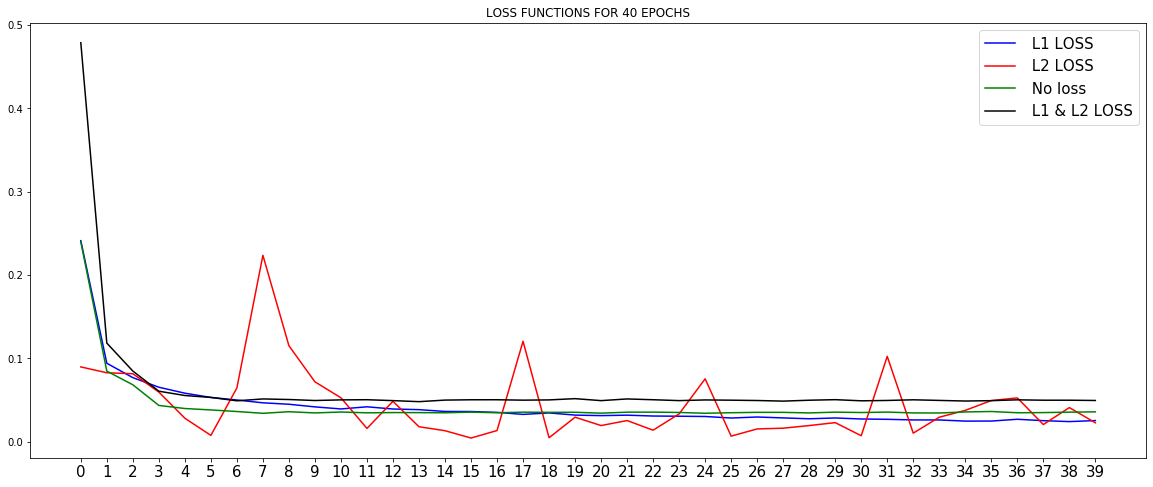

In [29]:
import matplotlib.pyplot as plt

def plot_losses(l1_loss,l2_loss,none_loss,both_loss):
  #epochs=12
  plt.figure(1,figsize=(20,8))
  plt.xticks(range(0,EPOCHS),fontsize=15)
  plt.yticks(fontsize=10)
  plt.plot(range(0,EPOCHS),l1_loss,'-b',label=' L1 LOSS')
  plt.plot(range(0,EPOCHS),l2_loss,'-r',label=' L2 LOSS')
  plt.plot(range(0,EPOCHS),none_loss,'-g',label=' No loss')
  plt.plot(range(0,EPOCHS),both_loss,'-k',label=' L1 & L2 LOSS')
  plt.legend(loc=0,fontsize=15)
  plt.title("LOSS FUNCTIONS FOR {} EPOCHS".format(EPOCHS))
  plt.show()

plot_losses(new_train_losses_l1,new_train_losses_l2,no_train_loss, new_train_losses_both)


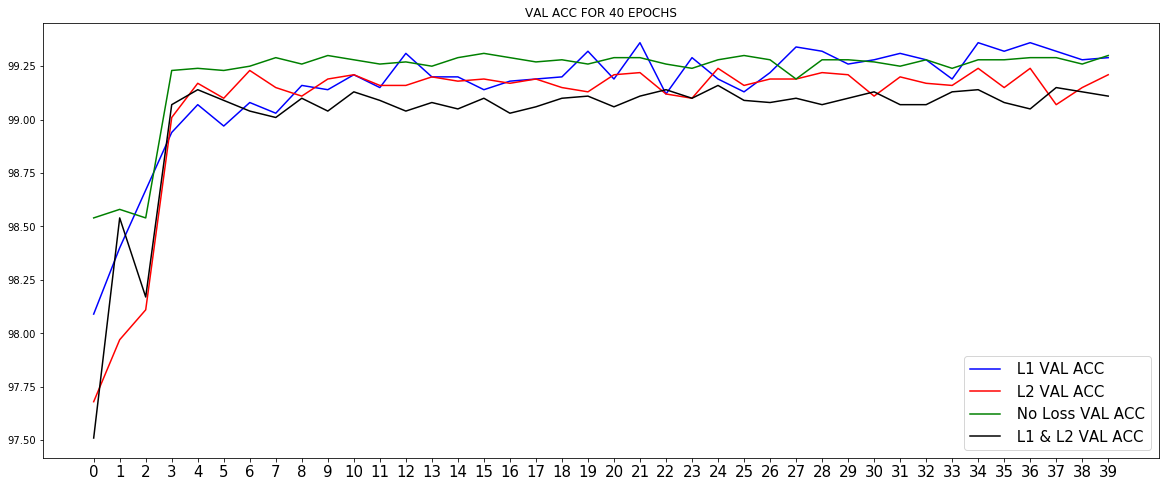

In [24]:
+def plot_losses_acc(l1_loss,l2_loss,none_loss,both_loss):
  #epochs=12
  plt.figure(1,figsize=(20,8))
  plt.xticks(range(0,EPOCHS),fontsize=15)
  plt.yticks(fontsize=10)
  plt.plot(range(0,EPOCHS),l1_loss,'-b',label=' L1 VAL ACC')
  plt.plot(range(0,EPOCHS),l2_loss,'-r',label=' L2 VAL ACC')
  plt.plot(range(0,EPOCHS),none_loss,'-g',label=' No Loss VAL ACC')
  plt.plot(range(0,EPOCHS),both_loss,'-k',label=' L1 & L2 VAL ACC')
  plt.legend(loc=0,fontsize=15)
  plt.title("VAL ACC FOR {} EPOCHS".format(EPOCHS))
  plt.show()

plot_losses_acc(l1_valid_acc,l2_valid_acc,no_valid_acc, both_valid_acc)


In [20]:
print (len(no_train_loss))
print (len(no_valid_acc))

print (len(new_train_losses_l2))
print (len(l2_valid_acc))

print (len(new_train_losses_l1))
print (len(l1_valid_acc))

print (len(new_train_losses_both))
print (len(both_valid_acc))

40
40
40
40
40
40
40
40


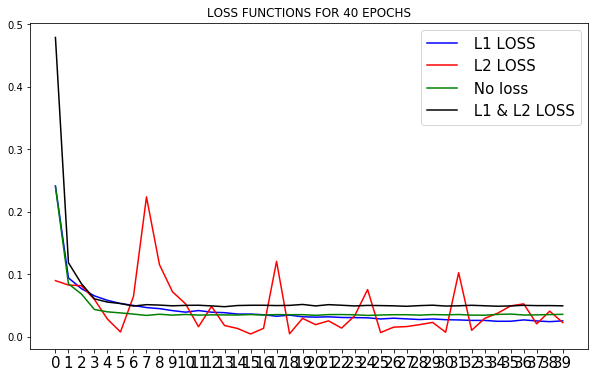

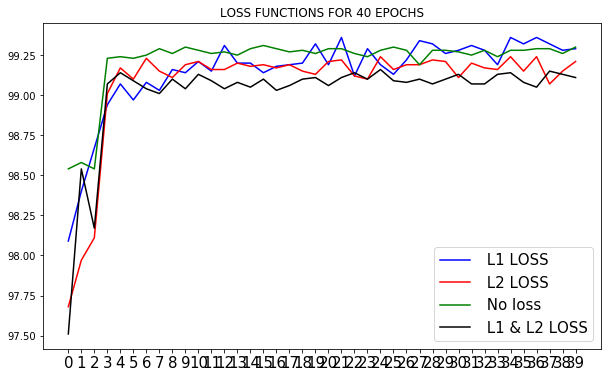

In [21]:
# EPOCHS = 3
# no_test_losses = []
# no_train_loss = []
# no_valid_acc = []

# new_train_losses_l2 =[]
# new_valid_losses_l2 =[]
# l2_valid_acc = []

# new_train_losses_l1 =[]
# new_valid_losses_l1 =[]
# l1_valid_acc = []

# new_valid_losses_both = []
# new_train_losses_both = []
# both_valid_acc= []

plot_losses(new_train_losses_l1,new_train_losses_l2,no_train_loss, new_train_losses_both)
plot_losses(l1_valid_acc,l2_valid_acc,no_valid_acc, both_valid_acc)


#plot_losses(new_valid_losses_l1,new_valid_losses_l2,no_loss_valid, new_valid_losses_both)


For misclassified images

(99.11, 0.02951251220703125)

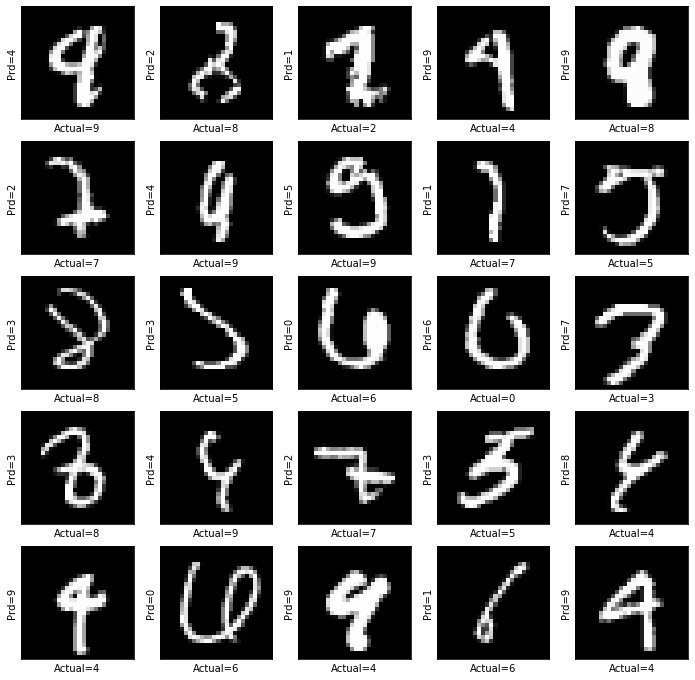

In [22]:
# Defining a new test loader with shuffle False for printing only
# first 25 misclassified images and fixed batch size



vis_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=10000, shuffle=False, **kwargs)


# Adding numpy for transforms

import numpy as np
def plot_classified(model,device,test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  preds = np.array([])
  actuals = np.array([])
  false_images = []
  total_false = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()
          true_labels = target.cpu().numpy()
          pred_labels = pred.squeeze().cpu().numpy()
          false_index = np.where(true_labels != pred_labels)[0]
          if (false_index.shape[0] > 0):
              for i in range(len(false_index)):            
                  off = false_index[i]
                  false_images.append(data[off].cpu().numpy().squeeze())
                  preds=np.append(preds, pred_labels[off])
                  actuals = np.append(actuals, true_labels[off])
                  total_false += 1
  test_loss /= len(test_loader.dataset)
  test_accuracy = (100. * correct) / len(test_loader.dataset)

  fig = plt.figure(figsize=(12,12))
  for i in np.arange(25):
      ax = fig.add_subplot(5, 5, i+1)
      plt.imshow(false_images[i],cmap='gray')
      plt.xticks([])
      plt.yticks([])
      ax.set(ylabel="Prd="+str(np.int(preds[i])), xlabel="Actual="+str(np.int(actuals[i])))

  return test_accuracy, test_loss


plot_classified(model,device,vis_loader)